## Source Localization starting with mean position of source

Author: Anmol Harshana

###### We already know that the time of arrival of wavelets can differ between the various receivers which are spread on the surface of moon. However, we can baseline source location as well as improve the prediction of receiver configuration if we have a fair enough baseline for source positon. So let's try the approach

1. Get a baseline source location by average value of time received on various receivers
2. Update source position to a better estimate (question is how)
3. Update receiver's guessed position to fit with this data.

In [6]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from numba import jit


In [7]:
# Testing out with 101 receivers and 

rec_pos_act= np.zeros(shape =(101,2))  # Assigning thr actual receiver position
rec_pos_act[:,:] = 0 # The deployer is at origin. 
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
t_rec_ideal = np.zeros(shape =(101,1))  # ideal value at receivers
rec_pos_mes= rec_pos_act +noise_r   
t_rec_ideal[0:101] = np.sqrt((rec_pos_mes[0:101,1]-100)**2 + (rec_pos_mes[0:101,0]-100)**2).reshape(101,1)
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (101,1))
t_Rec_real = t_rec_ideal + noise_t

c = 1 # velocity of propagation

# Note the different order in which the noises are added this time. 


In [8]:
# Getting the baseline value for source estimation

t_avg =np.mean(t_Rec_real)
source_pos = t_avg*c
x_start = source_pos/2  # Start search from the point of the half the radius
x_end = source_pos* np.sqrt(2)  # End search here
y_start = x_start
y_end = x_end

In [9]:
def src_Loc(rec_pos, t_rec,c,src_pos):
    '''The function returns the difference between the position of source(guessed) and receiver location as calculated from 
    measurement of time difference of arrival with the distance calculated from position of source and receiver. We aim to 
    minimise this quantity

    rec_pos = a matrix with position of receivers stored in the following format [[x_1, y_1],[x_2,y_2]]
    t_rec  = the time of arrival as measured from data
    source_loc = the guessed source location for which the function is being evaluated
    
    '''
    
    n_rec = np.shape(rec_pos)[0]
    t_rec_rel1 = np.zeros(shape=(n_rec-1,1))   # time difference calculated wrt the value in first receiver
    
    t_rec_rel1[:] = t_rec[1:] -t_rec[0]     
    
    rec_pos_src_rel = np.zeros(shape =(n_rec-1,2)) # Calculating the relative position of recivers wrt the source
    
    rec_pos_src_rel[:] = rec_pos[1:] -src_pos*np.ones_like(rec_pos_src_rel)  # relative position of receiver 1 wrt the source
    
    rec1_pos_src_rel = rec_pos[0] -src_pos # the position of receiver one wrt the source
    
    rec_dist_src_rel = np.zeros(shape=(n_rec-1,1))
    
    rec1_dist_src_rel = np.sqrt(rec1_pos_src_rel[0]**2 + rec1_pos_src_rel[1]**2)
    
    rec_dist_src_rel[:] = np.sqrt(rec_pos_src_rel[:,0]**2 + rec_pos_src_rel[:,1]**2).reshape(n_rec-1,1)
    
    delta_r = t_rec_rel1*c
    
    error = np.zeros(shape =(n_rec-1,1))   # defing the error to be minimized
    error[:] = delta_r[:] - (rec_dist_src_rel[:]-rec1_dist_src_rel)   
    
    error_to_min =np.dot(error.T,error) # Getting a single value instead of an array
    
    return error_to_min
        

In [5]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:]  # Can modify later if required
for i in range(1000):
    for j in range(1000): 
        if (x[i,j] > x_start and x [i,j] <x_end) or (x[i,j] < -x_start and x [i,j] > -x_end) or (y[i,j] < -y_start and y[i,j] > -y_end) or (y[i,j] > y_start and y[i,j] < y_end):
            error[i,j] = src_Loc(rec_pos=rec_pos_mes,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
        else:
            error[i,j] = np.max(error)+1e8
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

KeyboardInterrupt: 

We see an exact coincidence in the receiver and source location, now disturbing the receiver locations and then checking

In [ ]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_modified[:] = rec_pos_mes[:]+ noise_r # Can modify later if required
for i in range(1000):
    for j in range(1000): 
        if (x[i,j] > x_start and x [i,j] <x_end) or (x[i,j] < -x_start and x [i,j] > -x_end) or (y[i,j] < -y_start and y[i,j] > -y_end) or (y[i,j] > y_start and y[i,j] < y_end):
            error[i,j] = src_Loc(rec_pos=rec_pos_modified,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
        else:
            error[i,j] = np.max(error)+1e8
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

Noted time of computation for this function ~ 4 min, while without restricting domain ~ 1 min. Clearly, this is no good. 
A better way can be thought of only by radius comparison or better Instead of crisscrossing region we'll define a single region with only two conditions

In [ ]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_modified[:] = rec_pos_mes[:]+ noise_r # Can modify later if required
for i in range(1000):
    for j in range(1000): 
        if x[i,j] > x_start and y[i,j] > y_start:
            error[i,j] = src_Loc(rec_pos=rec_pos_modified,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
        else:
            error[i,j] = np.max(error)+1e8
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

Restricting the domain for source search won;t really help much. Some other possibilities to narrow the domain for source search are to use a radial measurement but it will also need two conditiond and will act similarly. Another way could be to use matrix approach instead of giving the value at each point using loops. Let's try both of these.

Text(0.5, 1.0, 'Error contour for receivers with error in both time of arrival and known position')

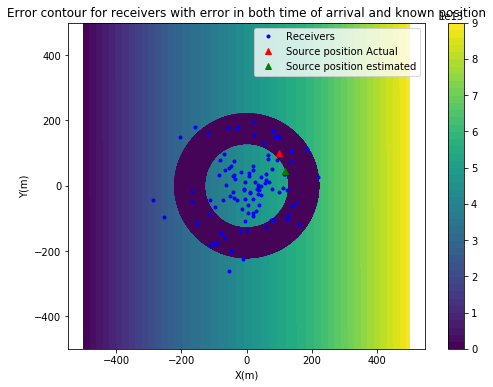

In [15]:
# 1 restricting by radial measurements
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_modified[:] = rec_pos_mes[:]+ noise_r # Can modify later if required
rad_domain = np.sqrt(x**2 + y**2) # radius from the origin of each point in domain
r_avg = t_avg*c
for i in range(1000):
    for j in range(1000): 
        if rad_domain[i,j] > r_avg  - 50  and  rad_domain[i,j] < r_avg  + 50:
            error[i,j] = src_Loc(rec_pos=rec_pos_modified,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
        else:
            error[i,j] = np.max(error)+1e8
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

Not much improvement is seen here. The time for running is around 8 min.Also no effective restriction is observed, we can try to do away with the else condition and check what happens. 

Text(0.5, 1.0, 'Error contour for receivers with error in both time of arrival and known position')

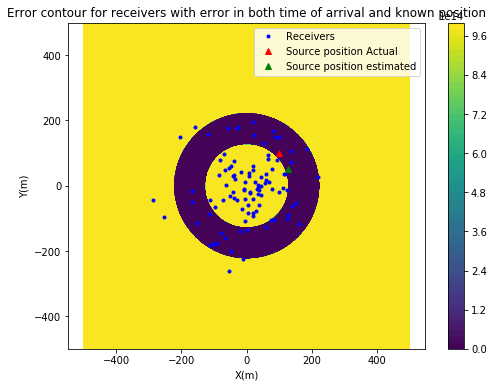

In [18]:
# 1 restricting by radial measurements
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = 1e15 * np.ones(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_modified[:] = rec_pos_mes[:]+ noise_r # Can modify later if required
rad_domain = np.sqrt(x**2 + y**2) # radius from the origin of each point in domain
r_avg = t_avg*c
for i in range(1000):
    for j in range(1000): 
        if rad_domain[i,j] > r_avg  - 50  and  rad_domain[i,j] < r_avg  + 50:
            error[i,j] = src_Loc(rec_pos=rec_pos_modified,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

We see that removing the else statement which depended on max value of error calculated leads to significant increase in speed time taken < 1 min. That is comparable to original scheme. To be more precise: It took only 8s for complete processing compared to around 40s in the original setting.
Next checking whether narrowing of search region will speed up further.

Text(0.5, 1.0, 'Error contour for receivers with error in both time of arrival and known position')

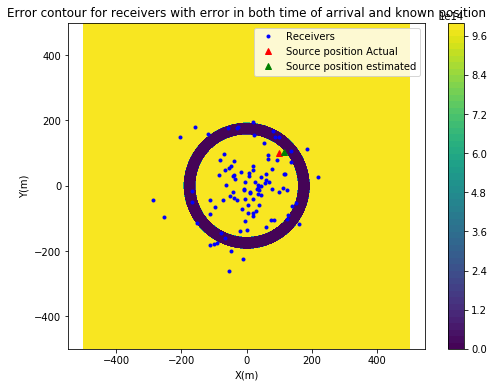

In [19]:
# 1 restricting by radial measurements
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = 1e15 * np.ones(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_modified[:] = rec_pos_mes[:]+ noise_r # Can modify later if required
rad_domain = np.sqrt(x**2 + y**2) # radius from the origin of each point in domain
r_avg = t_avg*c
for i in range(1000):
    for j in range(1000): 
        if rad_domain[i,j] > r_avg  - 20  and  rad_domain[i,j] < r_avg  + 20:
            error[i,j] = src_Loc(rec_pos=rec_pos_modified,t_rec=t_Rec_real,c=c,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

The computation is further reduced to around 4 to 5s. However, the actual source position is not contained within the limited region.